In [ ]:
# --- Load dataset and preprocessing pipeline ---

import os
import zipfile
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Path to saved dataset zip
zip_path = "/content/drive/MyDrive/dataset_split.zip"

# 3. Extract dataset into /content
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content")

# Base path to splits
base_split_path = "/content"

# --- Transforms  ---
from torchvision import transforms

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(25),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# --- Datasets
from torchvision import datasets

train_dir = os.path.join(base_split_path, "train")
val_dir   = os.path.join(base_split_path, "val")
test_dir  = os.path.join(base_split_path, "test")

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(root=val_dir, transform=val_transform)
test_dataset  = datasets.ImageFolder(root=test_dir, transform=test_transform)

# --- DataLoaders
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Quick check
print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Test samples:", len(test_dataset))
print("Classes:", train_dataset.classes[:5])

Mounted at /content/drive
Train samples: 14441
Val samples: 4127
Test samples: 2070
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define CNN model
class BaselineCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 256)   # after pooling down to 28×28
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Conv layers with ReLU + pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate model
num_classes = len(train_dataset.classes)
model = BaselineCNN(num_classes)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)

BaselineCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=15, bias=True)
)


In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

# Loss function: CrossEntropy
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Optional: Learning rate scheduler (to reduce LR if val loss plateaus)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3
)

print("✅ Loss, optimizer, and scheduler are ready.")

✅ Loss, optimizer, and scheduler are ready.


In [ ]:
import torch

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # Each epoch has training + validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # training mode
                dataloader = train_loader
            else:
                model.eval()   # evaluation mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Loop over batches
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if training
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Track metrics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Epoch stats
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Save history
            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc.item())
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc.item())
                # Step scheduler with validation loss
                scheduler.step(epoch_loss)

    return history

In [ ]:
history = train_model(model, criterion, optimizer, scheduler, num_epochs=5)


Epoch 1/5
------------------------------
train Loss: 1.1092 Acc: 0.6413
val Loss: 0.5664 Acc: 0.8117

Epoch 2/5
------------------------------
train Loss: 0.5426 Acc: 0.8204
val Loss: 0.4364 Acc: 0.8556

Epoch 3/5
------------------------------
train Loss: 0.4073 Acc: 0.8625
val Loss: 0.3776 Acc: 0.8793

Epoch 4/5
------------------------------
train Loss: 0.3168 Acc: 0.8929
val Loss: 0.2615 Acc: 0.9142

Epoch 5/5
------------------------------
train Loss: 0.2534 Acc: 0.9161
val Loss: 0.2624 Acc: 0.9176


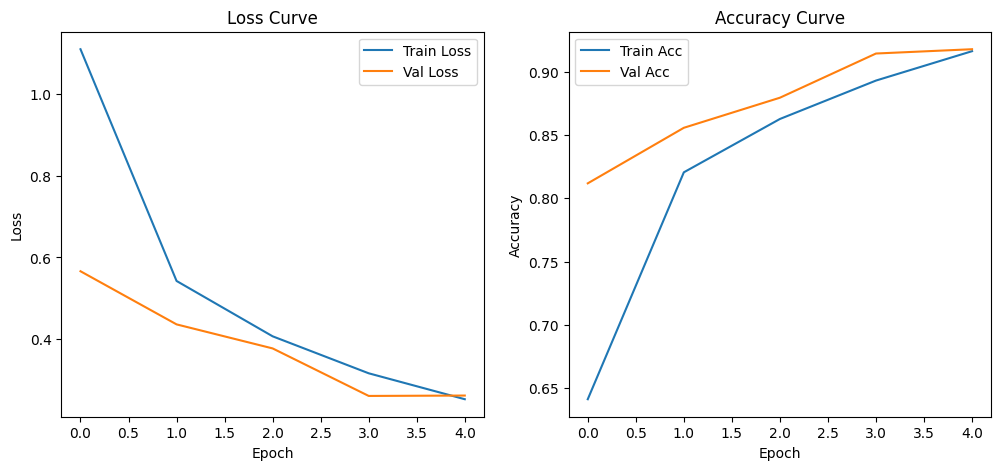

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Loss curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    # Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.show()

# Call after training
plot_history(history)